In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from totaling.core import WorkflowTotaler

## Totaling scratch work
Let's try a minimal totaling step:
- manually pass output from Deconto (AIS) and Bamber (AIS & GIS) modules
- These were run in `../experiment_level/docker-compose-bamber-fair.yml` (`docker compose -f docker-compose-bamer-fair.yml up`)
- Outputs are written to `../experiment_level/data/output`
- We're only looking at **global** outputs (for now)
- Pass a list of the files you watn to be totaled


In [41]:
file0 = "/Users/emmamarshall/Desktop/facts_work/facts_v2/experiment_level/data/output/ais_gslr.nc"
file1 = "/Users/emmamarshall/Desktop/facts_work/facts_v2/experiment_level/data/output/output_ais_gslr.nc"
file2 = "/Users/emmamarshall/Desktop/facts_work/facts_v2/experiment_level/data/output/output_gis_gslr.nc"

files_ls = [file0, file1, file2]

### Side trip: what do current module outputs look like? what would ideal module outputs be?

In [42]:
# this is an example of what a module writes currently
ds1_bare = xr.open_dataset(file0)
ds1_bare

<xarray.Dataset> Size: 20kB
Dimensions:           (samples: 500, years: 9, locations: 1)
Coordinates:
  * samples           (samples) int32 2kB 0 1 2 3 4 5 ... 495 496 497 498 499
  * years             (years) int32 36B 2020 2030 2040 2050 ... 2080 2090 2100
  * locations         (locations) int32 4B -1
Data variables:
    sea_level_change  (samples, years, locations) float32 18kB ...
    lat               (locations) float32 4B ...
    lon               (locations) float32 4B ...
Attributes:
    description:  Global SLR contribution from AIS from the Deconto et al. 20...
    history:      Created Sat Nov 15 01:14:12 2025
    scenario:     rcp85
    baseyear:     2000

Let's add some nicer structure to it (want structure to reflect physical meaning of data)
Add things like...
- what scenario used to force temp inputs to this module?
- What scale are the output projections (local or global)?
- What source do these outputs represent contributions from (AIS, WAIS, EAIS, GIS, glaciers, ...)?
- What module generated these outputs? 

^^ Each module produces a data cube with n-dimensions. All of these can vary across modules so they should probably be coordinates that exist along `file` (or something like that) dim.

In [ ]:
ds1 = ds1_bare.copy()
ds1.expand_dims("scenario")
ds1["scenario"] = [ds1.attrs["scenario"]]

ds1.expand_dims("scale")
ds1["scale"] = ["global"]

ds1.expand_dims("source")
ds1["source"] = ["AIS"]

ds1.expand_dims("module")
ds1["module"] = ["DeConto 2021"]

In [22]:
ds1

<xarray.Dataset> Size: 20kB
Dimensions:           (samples: 500, years: 9, locations: 1, scenario: 1,
                       scale: 1, source: 1, module: 1)
Coordinates:
  * samples           (samples) int32 2kB 0 1 2 3 4 5 ... 495 496 497 498 499
  * years             (years) int32 36B 2020 2030 2040 2050 ... 2080 2090 2100
  * locations         (locations) int32 4B -1
  * scenario          (scenario) <U5 20B 'rcp85'
  * scale             (scale) <U6 24B 'global'
  * source            (source) <U3 12B 'AIS'
  * module            (module) <U12 48B 'DeConto 2021'
Data variables:
    sea_level_change  (samples, years, locations) float32 18kB 8.42 ... 150.3
    lat               (locations) float32 4B inf
    lon               (locations) float32 4B inf
Attributes:
    description:  Global SLR contribution from AIS from the Deconto et al. 20...
    history:      Created Sat Nov 15 01:14:12 2025
    scenario:     rcp85
    baseyear:     2000

how should location data be handled/stored at this step?
(down the line) may want the final output to be a geospatial data cube? idk.... that would prob be very end/low priority

## Back to totaling

Pass list of file paths and a name (doesn't do anything rn) to `WorkflowTotaler`.

In [43]:
totaler = WorkflowTotaler(name="bamber_deconto_global_outputs", paths_list=files_ls)

- for now, have this `type_flag` arg, this is just to specify how/if the preprocess fn should parse the description `attr` of the module data cube (manually wrote something to pull names for bamber and deconto, `w/attrs` only works for those). `minimal` should work for other combos of modules (haven't been run yet)

In [35]:
totaler.total_projections(
    type_flag="w/ attrs",
)

AssertionError: No 'w/ attrs' projection dataset found. Did you run get_projections(scale='global', type_flag='w/ attrs')?

Once `WorkflowTotaler` created, call `get_projections(type_flag= ..., scale='global')` to read data cubes, add file dim and combine along file dim. 

In [44]:
totaler.get_projections(scale="global", type_flag="w/ attrs")

Then, call `WorkflowTotaler.total_projections()` method, this actually computes the sum and returns a `xr.DS`. 

In [45]:
global_ds_w_attrs = totaler.total_projections(type_flag="w/ attrs")
global_ds_w_attrs

<xarray.Dataset> Size: 92kB
Dimensions:                       (file: 3, samples: 500, years: 9, locations: 1)
Coordinates:
  * file                          (file) <U18 216B 'deconto_ais_global' ... '...
  * samples                       (samples) int32 2kB 0 1 2 3 ... 497 498 499
  * years                         (years) int32 36B 2020 2030 2040 ... 2090 2100
  * locations                     (locations) int32 4B -1
Data variables:
    sea_level_change              (file, samples, years, locations) float32 54kB dask.array<chunksize=(1, 500, 9, 1), meta=np.ndarray>
    lat                           (file, locations) float32 12B dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon                           (file, locations) float32 12B dask.array<chunksize=(1, 1), meta=np.ndarray>
    projections_sea_level_change  (samples, years, locations) float32 18kB dask.array<chunksize=(500, 9, 1), meta=np.ndarray>
    totaled_sea_level_change      (samples, years, locations) float32 18kB dask.array<chunksize=(500, 9, 1), meta=np.ndarray>
Attributes:
    description:  Summed global sealevel change projections from following so...
    history:      Created Sat Nov 15 01:14:12 2025
    scenario:     rcp85
    baseyear:     2000

In [46]:
totaler.get_projections(scale="global", type_flag="minimal")
global_ds_minimal = totaler.total_projections(type_flag="minimal")
global_ds_minimal

<xarray.Dataset> Size: 92kB
Dimensions:                   (file: 3, samples: 500, years: 9, locations: 1)
Coordinates:
  * file                      (file) <U3 36B 'abc' 'abc' 'abc'
  * samples                   (samples) int32 2kB 0 1 2 3 4 ... 496 497 498 499
  * years                     (years) int32 36B 2020 2030 2040 ... 2090 2100
  * locations                 (locations) int32 4B -1
Data variables:
    sea_level_change          (file, samples, years, locations) float32 54kB dask.array<chunksize=(1, 500, 9, 1), meta=np.ndarray>
    lat                       (file, locations) float32 12B dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon                       (file, locations) float32 12B dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_sea_level_change    (samples, years, locations) float32 18kB dask.array<chunksize=(500, 9, 1), meta=np.ndarray>
    totaled_sea_level_change  (samples, years, locations) float32 18kB dask.array<chunksize=(500, 9, 1), meta=np.ndarray>
Attributes:
    description:  Global SLR contribution from AIS from the Deconto et al. 20...
    history:      Created Sat Nov 15 01:14:12 2025
    scenario:     rcp85
    baseyear:     2000

^^ this one was run w/ `type_flag = 'minimal'`, no way of knowing which modules it includes.

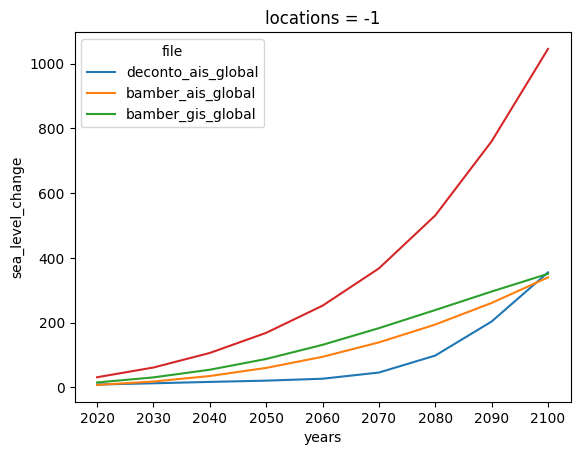

In [18]:
fig, ax = plt.subplots()
totaler.totaled_ds_global_w_attrs["sea_level_change"].squeeze().mean(
    dim="samples"
).plot(hue="file", ax=ax)
totaler.totaled_ds_global_w_attrs["sea_level_change"].sum(dim="file").mean(
    dim="samples"
).plot(ax=ax, label="total")